# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt          # plotting
from scipy.sparse import csr_matrix      # sparse matrices


## Load Wikipedia dataset

In [3]:
!ls

CLU02-NB01.ipynb
CLU02-NB02.ipynb
Clustering_week_2_assignment_1.ipynb
EXYf4uI8EemJfgqR2HI2sA_7748de6a71ad43ff82555fff1beb62bd_CLU02-NB02.ipynb.zip
EXYgfuI8Eemx8A5HK6Ls8g_209c6c4218c447e2bacf83ff59941983_CLU02-NB01.ipynb (1).zip
_167fc84b78dc145609e919983b475aaa_people_wiki.csv (1).zip
_395a4cfb2299d1655f1ef6bf6cc4f71b_people_wiki_tf_idf.npz (1).zip
_395a4cfb2299d1655f1ef6bf6cc4f71b_people_wiki_word_count.npz.zip
_96eadbec4d43a0b0870dde27d0652fb2_people_wiki_map_index_to_word.json (1).zip
clustering_week_2_assignment_2.ipynb
people_wiki.csv
people_wiki_map_index_to_word.json
people_wiki_tf_idf.npz
people_wiki_word_count.npz
retrieval-intro-annotated.pdf
sparse_matrix.png


In [4]:
wiki = pd.read_csv("people_wiki.csv")

In [5]:
# to add the column id same as the index
wiki['id'] = wiki.index

In [6]:
wiki.head()

,URI,name,text,id
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,0
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,1
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,2
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,3
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,4


In [7]:
wiki.iloc[1]['text']

'alfred j lewy aka sandy lewy graduated from university of chicago in 1973 after studying psychiatry pharmacology and ophthalmology he is a full professor and vicechair of the department of psychiatry at ohsu oregon health science university and holds an md and phd prior to moving to oregon in 1981 lewy was at the national institute of mental health nimh in bethesda maryland working with senior colleague thomas wehr in oregon he has worked closely with robert l sack as of december 2005 he had 94 publications available on pubmed he describes his research as follows my laboratory studies chronobiologic sleep and mood disorders these disorders include winter depression jet lag maladaptation to shift work and certain types of sleep disturbances relying on a very precise assay for plasma melatonin a hormone that has a clearly defined 24hour pattern of secretion biological rhythm disorders can be assessed and their treatment can be monitored current research is focused on developing bright l

## Extract word count vectors

For your convenience, we extracted the word count vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the word count vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

To load in the word count vectors, define the function

In [8]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [9]:
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [10]:
word_count

<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [11]:
word_count.shape

(59071, 547979)

In [12]:
word_count[0]

<1x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 139 stored elements in Compressed Sparse Row format>

The word-to-index mapping is given by

In [13]:
with open('people_wiki_map_index_to_word.json', 'r') as filehandle:
    people_wiki_map_index_to_word = json.load(filehandle)

In [14]:
people_wiki_map_index_to_word

{'biennials': 522004,
 'lb915': 116290,
 'shatzky': 127647,
 'woode': 174106,
 'damfunk': 133206,
 'nualart': 153444,
 'hatefillot': 164111,
 'missionborn': 261765,
 'yeardescribed': 161075,
 'theoryhe': 521685,
 'vinalop': 222759,
 'soestdijk': 166345,
 'boncea': 150371,
 'spiders': 519990,
 'bienniale': 429277,
 'woody': 541515,
 'trawling': 189895,
 'pampoulovawagner': 201040,
 'bentara': 202586,
 'laserbased': 25758,
 'caner': 346073,
 'canes': 478262,
 'canet': 436468,
 'iaspark': 395341,
 'categoriesborn': 12586,
 '5982': 277649,
 'caney': 459867,
 'phosphorushe': 379479,
 'yusaf': 270311,
 'hhsoffice': 141697,
 '5985': 32985,
 'fsos': 109474,
 'caned': 324502,
 'gaa': 534680,
 'iguau': 456103,
 'storiesin': 513151,
 'braziljorge': 107111,
 'iguaz': 127410,
 'kealhofer': 342134,
 'canek': 159182,
 '2116': 429919,
 'canem': 83461,
 'victorialooking': 58169,
 'martre': 111954,
 'lippert': 491344,
 'pagesolove': 33220,
 'sowell': 489254,
 'weiskopfs': 344360,
 'hedquist': 165506,
 '

In [15]:
people_wiki_map_index_to_word['chronobiologic']

381092

## Find nearest neighbors using word count vectors


Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance. For this, we will use scikit-learn's implementation of k-nearest neighbors. We first create an instance of the NearestNeighbor class, specifying the model parameters. Then we call the fit() method to attach the training set.

In [16]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [17]:
print (wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text     id  
35817  barack hussein obama ii brk husen bm born augu...  35817  


which locates Obama's article at index 35817.

Let us run the k-nearest neighbor algorithm with Obama's article. Since the NearestNeighbor class expects a vector, we pass the 35817th row of word_count vector.

In [18]:
word_count[35817].toarray()

array([[ 0,  0,  0, ..., 30, 21, 40]])

In [19]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

In [20]:
indices

array([[35817, 24478, 28447, 35357, 14754, 13229, 31423, 22745, 36364,
         9210]])

The query returns the indices of and distances to the 10 nearest neighbors. To display the indices and distances together with the article name, run

In [21]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

In [22]:
neighbors

,distance,id
0,0.000000,35817
1,33.075671,24478
2,34.394767,28447
3,36.152455,35357
4,36.166283,14754
5,36.331804,13229
6,36.400549,31423
7,36.496575,22745
8,36.633318,36364
9,36.959437,9210


In [23]:
result = wiki.merge(neighbors, on='id', how = 'inner')#.sort('distance') #[['id','name','distance']])

In [24]:
result.sort_values(by = 'distance')

,URI,name,text,id,distance
8,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,0.000000
4,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,24478,33.075671
5,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,28447,34.394767
7,<http://dbpedia.org/resource/Lawrence_Summers>,Lawrence Summers,lawrence henry larry summers born november 30 ...,35357,36.152455
2,<http://dbpedia.org/resource/Mitt_Romney>,Mitt Romney,willard mitt romney born march 12 1947 is an a...,14754,36.166283
1,<http://dbpedia.org/resource/Francisco_Barrio>,Francisco Barrio,francisco javier barrio terrazas born november...,13229,36.331804
6,<http://dbpedia.org/resource/Walter_Mondale>,Walter Mondale,walter frederick fritz mondale born january 5 ...,31423,36.400549
3,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...,22745,36.496575
9,<http://dbpedia.org/resource/Don_Bonker>,Don Bonker,don leroy bonker born march 7 1937 in denver c...,36364,36.633318
0,<http://dbpedia.org/resource/Andy_Anstett>,Andy Anstett,andrue john andy anstett born june 25 1946 is ...,9210,36.959437


## Interpreting the nearest neighbors

All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
Andy Anstett is a former politician in Manitoba, Canada.
Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama. To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

First, run the following cell to obtain the word_count column, which represents the word count vectors in the dictionary form. This way, we can quickly recognize words of great importance.

In [25]:
table = sorted(people_wiki_map_index_to_word, key=people_wiki_map_index_to_word.get)

In [26]:
table

['bioarchaeologist',
 'leaguehockey',
 'electionruss',
 'teramoto',
 'trumpeterpercussionist',
 'spoofax',
 'mendelssohni',
 'crosswise',
 'yec',
 'asianthemed',
 'masheldon',
 'maywoods',
 'feduring',
 'seameo',
 '2012green',
 'wrighthassell',
 'lidda',
 'wfo',
 'ukfang',
 'outfitover',
 'pagbabago',
 'influences1',
 'stonier',
 'brbbarbosa',
 'ipishuna',
 'researchteuvo',
 'stephensens',
 'titheridge',
 'dunlapi',
 'specs',
 'komozi',
 'fajita',
 'sauvagein',
 'brilliantmusik',
 'glickenhaus',
 '23seat',
 'selfloading',
 'tankians',
 '333465389',
 'reviewsbarasch',
 '89195',
 'arrestedon',
 'confisses',
 'unclog',
 'newbies',
 'mcin',
 'ecosocial',
 'sumiswald',
 'deleriums',
 'trochim',
 'darkenedfrom',
 '91ydsprofessional',
 'yorkcolomina',
 'athfest',
 'minutetraianidis',
 'radiograciette',
 'textsross',
 'epiculture',
 'firedheading',
 'redecoration',
 'krywult',
 'montanaform',
 'kyozan',
 'reformbestrebungen',
 'atlantaduring',
 'drumsshe',
 'athttpbelenfernandezwritingsblogspo

In [27]:
people_wiki_map_index_to_word['leaguehockey']

1

In [28]:
len(people_wiki_map_index_to_word)

547979

In [29]:
word_count.shape

(59071, 547979)

In [30]:
len(word_count.data)

10379283

In [31]:
word_count.indices

array([  5877,  92219, 227191, ..., 547976, 547977, 547978], dtype=int32)

In [32]:
word_count.indptr

array([       0,      139,      286, ..., 10379022, 10379155, 10379283],
      dtype=int32)

In [33]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data    # is an array containing all the non zero elements of the sparse matrix
    indices = matrix.indices   #  is an array mapping each element in data to its column in the sparse matrix
    indptr = matrix.indptr    # then maps the elements of data and indices to the rows of the sparse matrix
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

In [34]:
wiki['word_count'] = unpack_dict(word_count, people_wiki_map_index_to_word)

In [35]:
wiki.iloc[0]['word_count']

{'10': 1,
 '1979': 1,
 '19982000': 1,
 '2000': 1,
 '2001': 1,
 '2002': 1,
 '2003': 1,
 '2005': 1,
 '2006': 1,
 '2007': 1,
 '2008': 1,
 '2009': 1,
 '2011': 1,
 '2013': 1,
 '2014': 1,
 '21': 1,
 '32': 1,
 '44game': 1,
 'a': 4,
 'acted': 1,
 'afl': 1,
 'aflfrom': 1,
 'against': 2,
 'age': 1,
 'along': 1,
 'also': 1,
 'and': 4,
 'as': 2,
 'assistant': 1,
 'at': 4,
 'australia': 1,
 'australian': 3,
 'before': 2,
 'being': 1,
 'blues': 1,
 'born': 1,
 'box': 1,
 'brisbaneafter': 1,
 'bullants': 1,
 'by': 1,
 'career': 1,
 'carlton': 2,
 'carltons': 1,
 'cause': 1,
 'club': 5,
 'clubs': 1,
 'coach': 2,
 'coached': 1,
 'coburg': 1,
 'college': 1,
 'continued': 1,
 'corey': 1,
 'currently': 1,
 'david': 1,
 'delisted': 1,
 'digby': 1,
 'district': 1,
 'division': 1,
 'draft': 1,
 'drawn': 1,
 'during': 1,
 'early': 1,
 'edflhe': 1,
 'education': 1,
 'end': 2,
 'essendon': 1,
 'exchange': 1,
 'falcons': 1,
 'first': 1,
 'five': 1,
 'following': 1,
 'football': 10,
 'footballer': 1,
 'for': 4,
 

To make things even easier, we provide a utility function that displays a dictionary in tabular form:

In [36]:
row = wiki[wiki['name'] == 'Barack Obama']

In [37]:
word_count_table = row.iloc[0]['word_count']
word_count_table = pd.DataFrame(word_count_table.items(), columns = ['word', 'count'])
word_count_table.sort_values(by = 'count', ascending = False)

,word,count
272,the,40
270,in,30
271,and,21
269,of,18
266,to,14
...,...,...
94,budget,1
96,receive,1
99,convention,1
100,operation,1


In [38]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    #word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    word_count_table = row.iloc[0]['word_count']
    name_count = name+"_"+"count"
    word_count_table = pd.DataFrame(word_count_table.items(), columns = ['word', name_count])
    return word_count_table.sort_values(by = name_count, ascending = False)

obama_words = top_words('Barack Obama')
obama_words



,word,Barack Obama_count
272,the,40
270,in,30
271,and,21
269,of,18
266,to,14
...,...,...
94,budget,1
96,receive,1
99,convention,1
100,operation,1


In [39]:
barrio_words = top_words('Francisco Barrio')
barrio_words

,word,Francisco Barrio_count
224,the,36
221,of,24
223,and,18
222,in,17
212,he,10
...,...,...
82,dark,1
83,results,1
84,60,1
85,attempt,1


Let's extract the list of most frequent words that appear in both Obama's and Barrio's documents. We've so far sorted all words from Obama and Barrio's articles by their word frequencies. We will now use a dataframe operation known as join. The join operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the word column). See the documentation for more details.

In [40]:
combined_words = obama_words.merge(barrio_words, on = 'word', how='inner')
combined_words = combined_words.sort_values('Barack Obama_count', ascending=False)
combined_words_top_5 = combined_words[0:5]
combined_words_top_5['word'].tolist()

['the', 'in', 'and', 'of', 'to']

###### Quiz Question. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

Hint:

Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five.

Each word count vector is a Python dictionary. For each word count vector in SFrame, you'd have to check if the set of the 5 common words is a subset of the keys of the word count vector. Complete the function has_top_words to accomplish the task.

Convert the list of top 5 words into set using the syntax "set(common_words)", where common_words is a Python list. See this link if you're curious about Python sets.

Extract the list of keys of the word count dictionary by calling the keys() method.

Convert the list of keys into a set as well.

Use issubset() method to check if all 5 words are among the keys.

Now apply the has_top_words function on every row of the SFrame.

Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

In [41]:
wiki_test = wiki.head(5)
wiki_test['words'] = wiki_test['word_count'].apply(lambda x:set(x.keys()))

/Users/amitpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
wiki_test

,URI,name,text,id,word_count,words
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,0,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...","{2001, during, essendon, as, victorian, box, f..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,1,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...","{depression, colleague, chicago, take, relying..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,2,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...","{won, crossed, chicago, as, years, up, 1982, i..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,3,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...","{jeanpierre, fr, abe, 1963, shore, eighteen, o..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,4,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...","{producergenka, 2001, during, tour, 1974, revo..."


In [43]:
#common_words = ['the', 'in', 'and', 'of', 'to']

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    common_words = set(['the', 'in', 'and', 'of', 'to'])
    # return True if common_words is a subset of unique_words
    # return False otherwise
    if common_words.issubset(unique_words):
        return True
    else:
        return False


In [44]:
wiki_test['has_top_words'] = wiki_test['word_count'].apply(has_top_words)


/Users/amitpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
wiki_test

,URI,name,text,id,word_count,words,has_top_words
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,0,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...","{2001, during, essendon, as, victorian, box, f...",True
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,1,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...","{depression, colleague, chicago, take, relying...",True
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,2,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...","{won, crossed, chicago, as, years, up, 1982, i...",True
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,3,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...","{jeanpierre, fr, abe, 1963, shore, eighteen, o...",True
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,4,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...","{producergenka, 2001, during, tour, 1974, revo...",False


In [46]:
wiki_test['has_top_words'].sum()

4

In [47]:
wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

In [48]:
wiki.head(5)

,URI,name,text,id,word_count,has_top_words
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,0,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,1,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,2,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,3,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,4,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False


In [49]:
wiki['has_top_words'].sum()

56066

Quiz Answer - 56066

**Checkpoint**. Check your `has_top_words` function on two random articles:

In [50]:
len(wiki.iloc[32]['word_count'])

167

In [51]:

print('Output from your function:', has_top_words(wiki.iloc[32]['word_count']))
print('Correct output: True')
print('Also check the length of unique_words. It should be 167')
print(len(wiki.iloc[32]['word_count']))

print('Output from your function:', has_top_words(wiki.iloc[33]['word_count']))
print('Correct output: False')
print('Also check the length of unique_words. It should be 188')
print(len(wiki.iloc[33]['word_count']))

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
167
Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188
188


**Quiz Question.** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

Hint: For this question, take the row vectors from the word count matrix that correspond to Obama, Bush, and Biden. To compute the Euclidean distance between any two sparse vectors, use sklearn.metrics.pairwise.euclidean_distances.

In [52]:
wiki[wiki['name'].isin(['Barack Obama','George W. Bush', 'Joe Biden'])]

,URI,name,text,id,word_count,has_top_words
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,24478,"{'badn': 1, 'rbnt': 1, 'thomasbiden': 1, 'dela...",True
28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,28447,"{'torturebush': 1, 'kingdombush': 1, 'floridae...",True
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,"{'husen': 1, '2012obama': 1, 'laureateduring':...",True


In [53]:
select_indices = [24478,28447,35817]
word_count_3 = word_count[select_indices,:]

In [54]:
word_count_3.toarray()

array([[ 0,  0,  0, ..., 16, 19, 33],
       [ 0,  0,  0, ..., 22, 14, 39],
       [ 0,  0,  0, ..., 30, 21, 40]])

In [55]:
from sklearn.metrics.pairwise import euclidean_distances
joe_bush = euclidean_distances(word_count[24478], word_count[28447])
joe_obama = euclidean_distances(word_count[24478], word_count[35817])
bush_obama = euclidean_distances(word_count[28447], word_count[35817])

In [56]:
print(joe_bush,joe_obama,bush_obama)

[[32.75667871]] [[33.07567082]] [[34.39476704]]


**Quiz Question.** Collect all words that appear both in Barack Obama and George W. Bush pages. Out of those words, find the 10 words that show up most often in Obama's page.

In [57]:
bush_words = top_words('George W. Bush')

In [58]:
combined_words_obama_bush = obama_words.merge(bush_words, on = 'word', how='inner')
combined_words_obama_bush = combined_words_obama_bush.sort_values('Barack Obama_count', ascending=False)

In [59]:
combined_words_obama_bush

,word,Barack Obama_count,George W. Bush_count
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
...,...,...,...
61,before,1,1
62,2007,1,1
63,other,1,1
65,new,1,1


In [60]:
combined_words_obama_bush.head(10)

,word,Barack Obama_count,George W. Bush_count
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
5,his,11,6
6,act,8,3
7,he,7,8
8,a,7,6
9,law,6,1


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

## TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. TF-IDF (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common. Let us load in the TF-IDF vectors and repeat the nearest neighbor search.

For your convenience, we extracted the TF-IDF vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the TF-IDF vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

To load in the TF-IDF vectors, run

In [196]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In addition to the sparse matrix, we also store the TF-IDF vectors in dictionary form as well, to allow for easy interpretation.

In [199]:
wiki['tf_idf'] = unpack_dict(tf_idf, people_wiki_map_index_to_word)

In [200]:
wiki.head()

,URI,name,text,id,word_count,has_top_words,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,0,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,1,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,2,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True,"{'germanyover': 10.986495389225194, 'bluesgosp..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,3,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True,"{'fantasticrottensteiner': 10.986495389225194,..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,4,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1..."


### Find nearest neighbors using TF-IDF vectors

Since we are now using a different set of features, we should create a new nearest neighbor model. Create another instance of the NearestNeighbor class as follows. Then call the fit() method to associate it with the TF-IDF vectors.

In [201]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [202]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

In [203]:
neighbors_tf_idf = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
result_tf_idf = wiki.merge(neighbors_tf_idf, on='id', how = 'inner')
result_tf_idf.sort_values(by = 'distance')

,URI,name,text,id,word_count,has_top_words,tf_idf,distance
3,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,"{'husen': 1, '2012obama': 1, 'laureateduring':...",True,"{'husen': 10.986495389225194, '2012obama': 10....",0.000000
1,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,7914,"{'daschleschiliro': 1, 'schiliro': 2, 'waxman'...",True,"{'daschleschiliro': 10.986495389225194, 'schil...",106.861014
9,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,46811,"{'reconstructionsessions': 1, 'fifthmost': 1, ...",True,"{'reconstructionsessions': 10.986495389225194,...",108.871674
7,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,44681,"{'terminatorlee': 1, 'dccc': 1, 'factually': 1...",True,"{'terminatorlee': 10.986495389225194, 'dccc': ...",109.045698
4,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,38376,"{'nationspower': 1, 'monsterpower': 1, 'forbes...",True,"{'nationspower': 10.986495389225194, 'monsterp...",109.108106
0,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,6507,"{'2012menendez': 1, 'menendez': 1, 'texasin': ...",True,"{'2012menendez': 10.986495389225194, 'menendez...",109.781867
5,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,38714,"{'democratseric': 1, 'wyrick': 1, 'afj': 1, 'k...",True,"{'democratseric': 10.986495389225194, 'wyrick'...",109.957788
8,<http://dbpedia.org/resource/James_A._Guest>,James A. Guest,james alfred guest is an american lawyer and c...,44825,"{'handgun': 1, 'dma': 1, 'parenthood': 1, 'sta...",True,"{'handgun': 7.61919955923872, 'dma': 7.4899878...",110.413889
6,<http://dbpedia.org/resource/Roland_Grossenbac...,Roland Grossenbacher,dr roland edouard grossenbacher is a swiss att...,44368,"{'grossenbacher': 1, 'organisationhe': 1, 'edo...",True,"{'grossenbacher': 10.293348208665249, 'organis...",110.470609
2,<http://dbpedia.org/resource/Tulsi_Gabbard>,Tulsi Gabbard,tulsi gabbard born april 12 1981 is an america...,33417,"{'veteransgabbard': 1, 'gabbard': 1, 'hanneman...",True,"{'veteransgabbard': 10.986495389225194, 'gabba...",110.696998


Let's determine whether this list makes sense.
* With a notable exception of Roland Grossenbacher, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Schiliro's article as well.

In [205]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = row.iloc[0]['tf_idf']
    name_count = name+"_"+"count"
    word_count_table = pd.DataFrame(word_count_table.items(), columns = ['word', name_count])
    return word_count_table.sort_values(by = name_count, ascending = False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print (obama_tf_idf)

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
print (schiliro_tf_idf)

        word  Barack Obama_count
71     obama           43.295653
138      act           27.678223
97      iraq           17.747379
129  control           14.887061
191      law           14.722936
..       ...                 ...
267       is            0.055233
268        a            0.039334
270       in            0.028962
271      and            0.015648
272      the            0.004063

[273 rows x 2 columns]
                word  Phil Schiliro_count
1           schiliro            21.972991
42             staff            15.856442
17     congressional            13.547088
0    daschleschiliro            10.986495
13             obama             9.621256
..               ...                  ...
115               of             0.037406
114                a             0.028096
116               in             0.004827
117              and             0.004471
118              the             0.001016

[119 rows x 2 columns]


Using the join operation we learned earlier, try your hands at computing the common words shared by Obama's and Schiliro's articles. Sort the common words by their TF-IDF weights in Obama's document. The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

In [206]:
combined_obama_schiliro = obama_tf_idf.merge(schiliro_tf_idf, on='word', how = 'inner')

In [207]:
combined_obama_schiliro.sort_values(by='Barack Obama_count', ascending = False)

,word,Barack Obama_count,Phil Schiliro_count
0,obama,43.295653,9.621256
1,law,14.722936,7.361468
2,democratic,12.410689,6.205344
3,senate,10.164288,3.388096
4,presidential,7.386955,3.693478
5,president,7.226869,9.033587
6,policy,6.095386,3.047693
7,states,5.473201,1.824400
8,office,5.248173,2.624086
9,2011,5.107041,3.404694


The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

**Quiz Question**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [219]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    common_words = set(['obama','law','democratic','senate','presidential'])
    # return True if common_words is a subset of unique_words
    # return False otherwise
    if common_words.issubset(unique_words):
        return True
    else:
        return False

In [220]:
wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

In [221]:
wiki['has_top_words'].sum()

14

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of `model_tf_idf`. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden. 

The distance is larger than the distances we found for the 10 nearest neighbors. But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [223]:
wiki[wiki['name'].isin(['Barack Obama','George W. Bush', 'Joe Biden'])]

,URI,name,text,id,word_count,has_top_words,tf_idf
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,24478,"{'badn': 1, 'rbnt': 1, 'thomasbiden': 1, 'dela...",True,"{'badn': 10.986495389225194, 'rbnt': 10.986495..."
28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,28447,"{'torturebush': 1, 'kingdombush': 1, 'floridae...",False,"{'torturebush': 10.986495389225194, 'kingdombu..."
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,"{'husen': 1, '2012obama': 1, 'laureateduring':...",True,"{'husen': 10.986495389225194, '2012obama': 10...."


In [224]:
from sklearn.metrics.pairwise import euclidean_distances
joe_obama = euclidean_distances(tf_idf[24478], tf_idf[28447])
joe_obama

array([[134.42672222]])

In [235]:
# Comptue length of all documents
wiki['length'] = wiki['text'].apply(lambda x:len(x.split(" ")))

# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = wiki.merge(neighbors, on='id', how ='inner')[['id', 'name', 'length', 'distance']]
nearest_neighbors_euclidean = nearest_neighbors_euclidean.sort_values(by = 'distance')
print (nearest_neighbors_euclidean)

       id                    name  length    distance
58  35817            Barack Obama     540    0.000000
18   7914           Phil Schiliro     208  106.861014
79  46811           Jeff Sessions     230  108.871674
76  44681  Jesse Lee (politician)     216  109.045698
63  38376          Samantha Power     310  109.108106
..    ...                     ...     ...         ...
22   9884      Kenneth M. Pollack     229  113.784257
91  55613           Gary D. Solis     208  113.785437
11   6828      George J. Mitchell     214  113.793053
43  22695      Nicholas Liverpool     251  113.795142
6    4893      A. Thomas McLellan     206  113.816086

[100 rows x 4 columns]


In [236]:
nearest_neighbors_euclidean

,id,name,length,distance
58,35817,Barack Obama,540,0.000000
18,7914,Phil Schiliro,208,106.861014
79,46811,Jeff Sessions,230,108.871674
76,44681,Jesse Lee (politician),216,109.045698
63,38376,Samantha Power,310,109.108106
...,...,...,...,...
22,9884,Kenneth M. Pollack,229,113.784257
91,55613,Gary D. Solis,208,113.785437
11,6828,George J. Mitchell,214,113.793053
43,22695,Nicholas Liverpool,251,113.795142


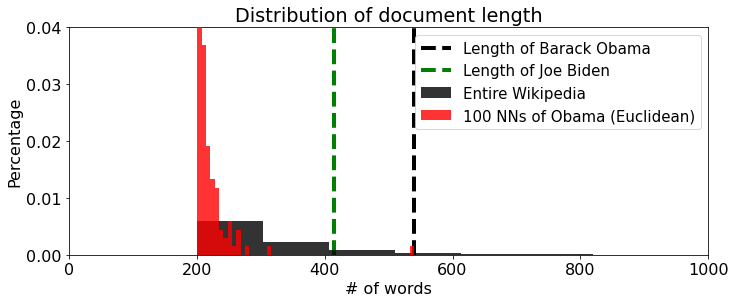

In [260]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density = True,\
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled',\
         density = True, label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki[wiki['name'] == 'Barack Obama'].iloc[0]['length'], color='k', linestyle='--', linewidth=4,\
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki[wiki['name'] == 'Joe Biden'].iloc[0]['length'], color='g', linestyle='--', linewidth=4,\
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.show()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [264]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = wiki.merge(neighbors, on='id')[['id', 'name', 'length', 'distance']]
nearest_neighbors_cosine = nearest_neighbors_cosine.sort_values(by = 'distance', ascending = True)
nearest_neighbors_cosine

,id,name,length,distance
59,35817,Barack Obama,540,0.000000
45,24478,Joe Biden,414,0.703139
65,38376,Samantha Power,310,0.742982
98,57108,Hillary Rodham Clinton,580,0.758358
67,38714,Eric Stern (politician),255,0.770561
...,...,...,...,...
76,43760,Jody Freeman,534,0.875848
49,28267,Michael C. Dorf,279,0.876000
85,48848,Greg Harris (Illinois politician),235,0.876418
0,686,"Jesse Jackson, Jr.",206,0.876957


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

<Figure size 756x324 with 0 Axes>

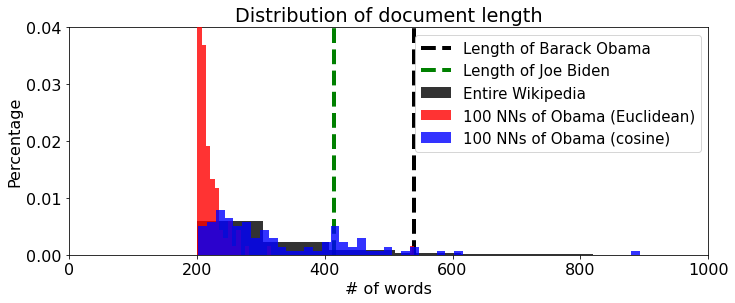

In [265]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki[wiki['name'] == 'Barack Obama'].iloc[0]['length'], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki[wiki['name'] == 'Joe Biden'].iloc[0]['length'], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.show()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

# Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [266]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [287]:
word_indices = word_indices = [table.index(word) for word in tweet.keys()]
tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )

Now, compute the cosine distance between the Barack Obama article and this tweet:

In [289]:
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = tf_idf[35817]
print (cosine_distances(obama_tf_idf, tweet_tf_idf))

[[0.70591838]]


Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors:

In [291]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)
print (distances)

[[0.         0.70313868 0.7429819  0.7583584  0.77056123 0.7846775
  0.78803907 0.79092642 0.7983226  0.79946636]]


With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden!  This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.

### Quiz

In [61]:
sentence_1 = [2,0,1,1,1,1,1,1,1,0]
sentence_2 = [0,2,2,1,1,0,0,0,1,1]

In [62]:
from scipy.spatial import distance
a = sentence_1
b = sentence_2
dst = distance.euclidean(a, b)

In [64]:
dst

3.605551275463989

In [65]:
math.sqrt(13)

3.605551275463989

In [68]:
from scipy import spatial
cosine_similarity = 1 - spatial.distance.cosine(sentence_1, sentence_2)
print(cosine_similarity)

0.4351941398892446
